<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Prototype Target Dashboard</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2024-06-12 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container size: medium <br>

**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This initial version focuses on AuxTel observations, but should be useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/PREOPS-5002>PREOPS-5002</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

## 1. Introduction

### 1.1 Import Packages

In [1]:
import sys
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import healpy as hp
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

import warnings

### 1.2. Define functions and parameters

Create a function to create a pandas DataFrame, df_grouped, that contains the results of performing a 2D groupby operation on a pandas DataFrame, df, and counts the number of entries in the col_count column for each (col_x, col_y).  One can choose to include a count of zero for cases where (col_x, col_y) have no entries in col_count (the default), or to exclude those cases.  The resulting pandas DataFrame, df_grouped, is also sorted by (col_x, col_y).

In [2]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df2Dgroupby(df, col_x, col_y, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y])
        )
        
    return df_grouped

Let us also do the same, but for performing the `groupby` over 3 columns.  (Should just generalize this to `N` columns, but that can wait...) 

In [3]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df3Dgroupby(df, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y, col_z])
        )
        
    return df_grouped

Create a function to plot an annotated headmap for a pandas DataFrame created by the above `df2Dgroupby` function.

In [4]:
# With a little help from https://seaborn.pydata.org/generated/seaborn.heatmap.html ...

def plotAnnotatedHeatMap_df2Dgroupby(df_grouped, col_index, col_column, col_values, title='Annotated Heatmap', cmap='Blues'):

    # Estimate a good figure size in x,y for the resulting plot...
    figsize_x = df_grouped[col_column].unique().size
    figsize_y = df_grouped[col_index].unique().size
    if figsize_y < 3:
        figsize_y = 1
    else:
        figsize_y = round(figsize_y/3)
    
    # Pivot the DataFrame to works with Seaborn heatmap...
    pivot_table = df_grouped.pivot(index=col_index, columns=col_column, values=col_values)
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    #fig, ax = plt.subplots(figsize=(5, 15))
    #fig, ax = plt.subplots()

    # Plot the annoated heatmap...
    sns.heatmap(pivot_table, annot=True, cmap=cmap, linecolor='Black', linewidths=0.1, ax=ax)

    # Add labels and title and rotate the x tick labels by 90 degrees...
    ax.set_xlabel(col_column)
    ax.set_ylabel(col_index)
    ax.set_title(title)
    plt.xticks(rotation=90)

Define some healpix tools.  I got this version from Sahar Allam on 2016-07-08, likely based on code from Alex Drlica-Wagner.

In [5]:
##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################

Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:

In [6]:
warnings.filterwarnings("ignore")

Set default backend for afwDisplay to `matplotlib`:

In [7]:
afwDisplay.setDefaultBackend('matplotlib')

Set a few parameters to use later, when plotting:

In [8]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Define repo, collection, instrument, and day of observation to study:

In [9]:
#repo = "/sdf/group/rubin/repo/main"
#repo="/sdf/group/rubin/repo/oga/"
#collection='LATISS/raw/all'
#instrument = 'LATISS'
#day_obs = 20240422

# Ops Rehearsal 3, "Intermittent Cumulative DRP: of the 3 nights of ops rehearsal 3 data
#  (https://confluence.lsstcorp.org/display/DM/Campaigns)
repo = "/repo/embargo"
collection='LSSTComCamSim/quickLook/24'
instrument = 'LSSTComCamSim'
day_obs = 20240404


Define columns to groupby and plot against each other:

In [10]:
col_sciprog = 'science_program'
#col_target = 'target'
col_target = 'HPX64'  # HPX64 is used as a proxy for target_name or block
col_filter = 'filter'
col_id = 'id'

## 2. Access data for this repo, collection, and day of observation

### 2.1 Instantiate butler and create registry

In [11]:
butler = dafButler.Butler(repo)
registry = butler.registry

Determine which dataset types exist in the collection.
(Based on material from `ops_rehearsal_comcam_analysis.ipynb`.)

In [12]:
i=0
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)
            i = i+1
print(i)

DatasetType('packages', {}, Packages)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
DatasetType('icSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('icExpBackground', {band, instrument, day_obs, detector, physical_filter, visit}, Background)
DatasetType('icExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
DatasetType('src', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('calexpBackground', {band, instrument, day_obs, detector, physical_filter, visit}, Background)
DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('srcMatchFull', {band, instrument, day_obs, detector, physical_filter, visit}, Catalog)
DatasetType('srcMatch', {band, instrument, day_obs, detector,

What fields are available from the `exposure` dimension?

In [13]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  day_obs: int
  group: str
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  seq_num: int
  seq_start: int
  seq_end: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  can_see_sky: bool
  timespan: lsst.daf.butler.Timespan


Good!  We have some useful info here, including the `target_name` and the `science_program`.

### 2.2 Read in information from the `exposure` dimension

Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and day of observation.

In [14]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('exposure',where=query)
#results = registry.queryDimensionRecords('exposure',where="instrument='LATISS' AND day_obs=20240422")

How many results were returned?

In [15]:
results.count()

780

### 2.3 Create and fill a pandas `DataFrame` containing useful info from the `queryDimensionRecords` query

Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension.

<span style="color:red; font-weight:bold">Like much else, I stole a lot of this from Sylvie's notebook.  What other useful info is accessible from the `exposure` dimension?  Answer:  probably no other useful info from the `exposure` dimension.  Need to grab other info from elsewhere.</span>


In [16]:
df_exposure = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

Read the query results into the new pandas `DataFrame`.

<span style="color:red; font-weight:bold">Iterating in python is generally slow if there are a lot of rows.  Are there any methods that quickly convert a `queryDimensionRecords` result to an AstroPy `table` or a pandas `DataFrame`?  It's not so bad for a single night, though; so maybe don't worry about it now.</span>


In [17]:
#for count, info in enumerate(registry.queryDimensionRecords('exposure',where= "instrument='LATISS'")):
for count, info in enumerate(results):
    
    
    try:
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info.timespan.begin.to_string()),
                                  pd.to_datetime(info.timespan.end.to_string()),
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    
    if count < 5:
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
        print(info)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        
        mjd = Time(info.timespan.begin.to_string()).mjd
        jd = Time(info.timespan.begin.to_string()).jd
        print(mjd,jd)

    elif ((count%100)==0):
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
 

----------------------------------------------------- 0 ---------------------------------------------------------
exposure:
  instrument: 'LSSTComCamSim'
  id: 7024040400028
  day_obs: 20240404
  group: '2024-04-04T23:50:44.936'
  physical_filter: 'g_01'
  obs_id: 'CC_S_20240404_000028'
  exposure_time: 30.0
  dark_time: 33.0528
  observation_type: 'science'
  observation_reason: 'object'
  seq_num: 28
  seq_start: 28
  seq_end: 28
  target_name: 'UNKNOWN'
  science_program: 'ops-rehearsal-3'
  tracking_ra: 125.12471453454675
  tracking_dec: -14.851590864293003
  sky_angle: 146.5822645690662
  azimuth: 16.61210029712818
  zenith_angle: 15.898935609720453
  has_simulated: True
  can_see_sky: True
  timespan: Timespan(begin=astropy.time.Time('2024-04-04 23:51:31.067013', scale='tai', format='iso'), end=astropy.time.Time('2024-04-04 23:52:04.119000', scale='tai', format='iso'))
	 id:                   7024040400028
	 day_obs:              20240404
	 seq_num:              28
	 type-of-obse

Let's look at the contents of the now-filled pandas `DataFrame`.

In [18]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,7024040400028,CC_S_20240404_000028,20240404,28,2024-04-04 23:51:31.067013,2024-04-04 23:52:04.119,science,UNKNOWN,g_01,15.898936,30.0,125.124715,-14.851591,146.582265,16.612100,15.898936,ops-rehearsal-3,2.460405e+06,60404.994110
1,7024040400001,CC_S_20240404_000001,20240404,1,2024-04-04 23:30:54.744007,2024-04-04 23:31:27.798,science,UNKNOWN,r_03,17.598434,30.0,125.098899,-15.036482,120.356983,32.877949,17.598434,ops-rehearsal-3,2.460405e+06,60404.979800
2,7024040400010,CC_S_20240404_000010,20240404,10,2024-04-04 23:37:08.852981,2024-04-04 23:37:41.906,science,UNKNOWN,r_03,16.942294,30.0,124.874108,-14.901806,107.465919,27.477343,16.942294,ops-rehearsal-3,2.460405e+06,60404.984130
3,7024040400035,CC_S_20240404_000035,20240404,35,2024-04-04 23:56:22.081005,2024-04-04 23:56:55.133,science,UNKNOWN,g_01,15.496796,30.0,125.203459,-15.008136,137.010449,12.788338,15.496796,ops-rehearsal-3,2.460405e+06,60404.997478
4,7024040400029,CC_S_20240404_000029,20240404,29,2024-04-04 23:52:12.403019,2024-04-04 23:52:45.457,science,UNKNOWN,g_01,15.752165,30.0,125.078767,-14.948524,145.140738,15.950579,15.752165,ops-rehearsal-3,2.460405e+06,60404.994588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,7024040400776,CC_S_20240404_000776,20240404,776,2024-04-05 10:08:47.558018,2024-04-05 10:09:20.613,science,UNKNOWN,r_03,22.919382,30.0,300.159351,-41.047094,173.169594,124.770899,22.919382,ops-rehearsal-3,2.460406e+06,60405.422773
776,7024040400777,CC_S_20240404_000777,20240404,777,2024-04-05 10:09:28.921986,2024-04-05 10:10:01.974,science,UNKNOWN,r_03,22.670992,30.0,300.062454,-40.881522,172.096782,124.549454,22.670992,ops-rehearsal-3,2.460406e+06,60405.423251
777,7024040400778,CC_S_20240404_000778,20240404,778,2024-04-05 10:10:10.356000,2024-04-05 10:10:43.411,science,UNKNOWN,r_03,22.410582,30.0,299.843691,-40.931590,171.608512,124.940277,22.410582,ops-rehearsal-3,2.460406e+06,60405.423731
778,7024040400779,CC_S_20240404_000779,20240404,779,2024-04-05 10:10:51.757988,2024-04-05 10:11:24.809,science,UNKNOWN,r_03,22.312061,30.0,299.939995,-40.806568,170.400302,124.685602,22.312061,ops-rehearsal-3,2.460406e+06,60405.424210


Let's re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s.

In [19]:
df_exposure = df_exposure.astype({"id": int,'day_obs': int,'seq_num':int})

And also replace `nan`'s in the `ra` and `dec` columns with zero.  (`nan`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.)

In [20]:
df_exposure['ra'] = df_exposure['ra'].fillna(0)
df_exposure['dec'] = df_exposure['dec'].fillna(0)

And look at `df_exposure` once again.

In [21]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,7024040400028,CC_S_20240404_000028,20240404,28,2024-04-04 23:51:31.067013,2024-04-04 23:52:04.119,science,UNKNOWN,g_01,15.898936,30.0,125.124715,-14.851591,146.582265,16.612100,15.898936,ops-rehearsal-3,2.460405e+06,60404.994110
1,7024040400001,CC_S_20240404_000001,20240404,1,2024-04-04 23:30:54.744007,2024-04-04 23:31:27.798,science,UNKNOWN,r_03,17.598434,30.0,125.098899,-15.036482,120.356983,32.877949,17.598434,ops-rehearsal-3,2.460405e+06,60404.979800
2,7024040400010,CC_S_20240404_000010,20240404,10,2024-04-04 23:37:08.852981,2024-04-04 23:37:41.906,science,UNKNOWN,r_03,16.942294,30.0,124.874108,-14.901806,107.465919,27.477343,16.942294,ops-rehearsal-3,2.460405e+06,60404.984130
3,7024040400035,CC_S_20240404_000035,20240404,35,2024-04-04 23:56:22.081005,2024-04-04 23:56:55.133,science,UNKNOWN,g_01,15.496796,30.0,125.203459,-15.008136,137.010449,12.788338,15.496796,ops-rehearsal-3,2.460405e+06,60404.997478
4,7024040400029,CC_S_20240404_000029,20240404,29,2024-04-04 23:52:12.403019,2024-04-04 23:52:45.457,science,UNKNOWN,g_01,15.752165,30.0,125.078767,-14.948524,145.140738,15.950579,15.752165,ops-rehearsal-3,2.460405e+06,60404.994588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,7024040400776,CC_S_20240404_000776,20240404,776,2024-04-05 10:08:47.558018,2024-04-05 10:09:20.613,science,UNKNOWN,r_03,22.919382,30.0,300.159351,-41.047094,173.169594,124.770899,22.919382,ops-rehearsal-3,2.460406e+06,60405.422773
776,7024040400777,CC_S_20240404_000777,20240404,777,2024-04-05 10:09:28.921986,2024-04-05 10:10:01.974,science,UNKNOWN,r_03,22.670992,30.0,300.062454,-40.881522,172.096782,124.549454,22.670992,ops-rehearsal-3,2.460406e+06,60405.423251
777,7024040400778,CC_S_20240404_000778,20240404,778,2024-04-05 10:10:10.356000,2024-04-05 10:10:43.411,science,UNKNOWN,r_03,22.410582,30.0,299.843691,-40.931590,171.608512,124.940277,22.410582,ops-rehearsal-3,2.460406e+06,60405.423731
778,7024040400779,CC_S_20240404_000779,20240404,779,2024-04-05 10:10:51.757988,2024-04-05 10:11:24.809,science,UNKNOWN,r_03,22.312061,30.0,299.939995,-40.806568,170.400302,124.685602,22.312061,ops-rehearsal-3,2.460406e+06,60405.424210


Let's add some Healpix info...

Let's aim for a couple different healpixel sizes:  one *very* roughly the area of a ComCam field-of-view (NSIDE=2^6=64) and one *very* roughly the area of an LSSTCam field-of-view (NSIDE=2^4=16).

In [22]:
# Very roughly the area of a ComCam field-of-view (c. 0.5 sq deg)
nside=2**6
# Area in sq deg:
area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in degrees: 
length = math.sqrt(area)
print(nside, area, length)

# Very roughly the area of an LSSTCam field-of-view (c. 9.6 sq deg)
nside=2**4
# Area in sq deg:
area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in degrees: 
length = math.sqrt(area)
print(nside, area, length)


64 0.8392936452111668 0.9161297098179748
16 13.428698323378669 3.6645188392718993


In [23]:
df_exposure.loc[:,'HPX64'] = getipix(64, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)
df_exposure.loc[:,'HPX16'] = getipix(16, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter,zenith_angle,...,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd,HPX64,HPX16
0,7024040400028,CC_S_20240404_000028,20240404,28,2024-04-04 23:51:31.067013,2024-04-04 23:52:04.119,science,UNKNOWN,g_01,15.898936,...,125.124715,-14.851591,146.582265,16.612100,15.898936,ops-rehearsal-3,2.460405e+06,60404.994110,40664,2541
1,7024040400001,CC_S_20240404_000001,20240404,1,2024-04-04 23:30:54.744007,2024-04-04 23:31:27.798,science,UNKNOWN,r_03,17.598434,...,125.098899,-15.036482,120.356983,32.877949,17.598434,ops-rehearsal-3,2.460405e+06,60404.979800,40664,2541
2,7024040400010,CC_S_20240404_000010,20240404,10,2024-04-04 23:37:08.852981,2024-04-04 23:37:41.906,science,UNKNOWN,r_03,16.942294,...,124.874108,-14.901806,107.465919,27.477343,16.942294,ops-rehearsal-3,2.460405e+06,60404.984130,40664,2541
3,7024040400035,CC_S_20240404_000035,20240404,35,2024-04-04 23:56:22.081005,2024-04-04 23:56:55.133,science,UNKNOWN,g_01,15.496796,...,125.203459,-15.008136,137.010449,12.788338,15.496796,ops-rehearsal-3,2.460405e+06,60404.997478,40664,2541
4,7024040400029,CC_S_20240404_000029,20240404,29,2024-04-04 23:52:12.403019,2024-04-04 23:52:45.457,science,UNKNOWN,g_01,15.752165,...,125.078767,-14.948524,145.140738,15.950579,15.752165,ops-rehearsal-3,2.460405e+06,60404.994588,40664,2541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,7024040400776,CC_S_20240404_000776,20240404,776,2024-04-05 10:08:47.558018,2024-04-05 10:09:20.613,science,UNKNOWN,r_03,22.919382,...,300.159351,-41.047094,173.169594,124.770899,22.919382,ops-rehearsal-3,2.460406e+06,60405.422773,47515,2969
776,7024040400777,CC_S_20240404_000777,20240404,777,2024-04-05 10:09:28.921986,2024-04-05 10:10:01.974,science,UNKNOWN,r_03,22.670992,...,300.062454,-40.881522,172.096782,124.549454,22.670992,ops-rehearsal-3,2.460406e+06,60405.423251,47515,2969
777,7024040400778,CC_S_20240404_000778,20240404,778,2024-04-05 10:10:10.356000,2024-04-05 10:10:43.411,science,UNKNOWN,r_03,22.410582,...,299.843691,-40.931590,171.608512,124.940277,22.410582,ops-rehearsal-3,2.460406e+06,60405.423731,47515,2969
778,7024040400779,CC_S_20240404_000779,20240404,779,2024-04-05 10:10:51.757988,2024-04-05 10:11:24.809,science,UNKNOWN,r_03,22.312061,...,299.939995,-40.806568,170.400302,124.685602,22.312061,ops-rehearsal-3,2.460406e+06,60405.424210,47515,2969


### 2.4 Read in the EFD for the day of observation

(Based on material from `ops_rehearsal_comcam_analysis.ipynb`)

<span style="color:red; font-weight:bold">Note much luck just yet using the EFD data.</span>


In [24]:
from lsst_efd_client import EfdClient
client = EfdClient("usdfdev_efd", db_name="lsst.dm")

In [25]:
topics = await client.get_topics()
for t in topics: print(t)

lsst.dm.NumDiaSources
lsst.dm.NumStreakCenterDiaSources
lsst.dm.NumStreakDiaSources
lsst.dm.ap12PsfSky
lsst.dm.astromColorDiffMetrics
lsst.dm.astromDiffMetrics
lsst.dm.blendMetrics
lsst.dm.calexpMetrics
lsst.dm.calexpSummaryMetrics
lsst.dm.calibrate
lsst.dm.constantTool
lsst.dm.diaSourcesGoodVsBadRatio
lsst.dm.diffimMetadataMetric
lsst.dm.e1Diff
lsst.dm.e1DiffScatterMetric
lsst.dm.e2Diff
lsst.dm.e2DiffScatterMetric
lsst.dm.isolatedDeblenderMetrics
lsst.dm.matchedRefAngularSeparationChi
lsst.dm.matchedRefAngularSeparationDiff
lsst.dm.matchedRefCModelColorChi
lsst.dm.matchedRefCModelColorDiff
lsst.dm.matchedRefCModelFluxChiMetric
lsst.dm.matchedRefCModelMagChi
lsst.dm.matchedRefCModelMagDiff
lsst.dm.matchedRefCModelMagDiffMetric
lsst.dm.matchedRefMagChiMetric
lsst.dm.matchedRefPositionDecChi
lsst.dm.matchedRefPositionDecDiff
lsst.dm.matchedRefPositionRaChi
lsst.dm.matchedRefPositionRaDiff
lsst.dm.matchedRefPositionXChi
lsst.dm.matchedRefPositionXChiMetric
lsst.dm.matchedRefPositionXDiff


In [26]:
#query = '''SELECT * FROM "lsst.dm.e1Diff" WHERE time > now() - 100d '''
#query = '''SELECT * FROM "lsst.dm.calexpMetrics" WHERE time > now() - 100d'''
#query = '''SELECT instrument FROM "lsst.dm.calexpMetrics" WHERE (time > now() - 100d)'''
query = """SELECT * FROM "lsst.dm.calexpMetrics" WHERE instrument='LSSTComCamSim' and (time > now() - 100d)"""

#query = '''SELECT DISTINCT day_obs FROM "lsst.dm.calexpMetrics"'''
df = await client.influx_client.query(query)
#df.columns.values
#df.iloc[0]
df

,astromOffsetMean,astromOffsetStd,band,band_1,dataset_tag,dataset_tag_1,dataset_type,day_obs,dec,detector,...,run_timestamp,skyBg,skyNoise,skymap,timestamp,tract,visit,visit_1,zenithDistance,zeroPoint
2024-04-01 23:04:49+00:00,0.007535,0.004387,r,r,Generic,Generic,calexpSummary_metrics,,-14.898025,1,...,1712012689,621.163452,21.164419,,1712012689,,7024040100020,7024040100020,47.817162,31.234436
2024-04-01 23:39:17+00:00,0.007535,0.004387,r,r,LSSTComCamSim/test_ctslater,LSSTComCamSim/test_ctslater,calexpSummary_metrics,,-14.898025,1,...,1712014757,621.163452,21.164419,,1712014757,,7024040100020,7024040100020,47.817162,31.234436
2024-04-02 00:03:29+00:00,0.006874,0.003926,r,r,LSSTComCamSim/test_ctslater,LSSTComCamSim/test_ctslater,calexpSummary_metrics,,-14.665673,2,...,1712016209,634.398071,22.057919,,1712016209,,7024040100020,7024040100020,47.955143,31.255642


## 3. Analyse results of the query

For the rest of the notebook, we do not want to restrict the the number of rows displayed for
pandas tabular information.  Therefore, let us turn off the pandas maximum rows setting.  We will turn it back on at the end of the notebook.

In [27]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

### 3.1 Counts

First, let's tabulate the counts of different types of exposures taken on this date.

In [28]:
df_exposure.groupby("type").count()["id"]

type
science    780
Name: id, dtype: int64

We are primarily interested in just the science exposures.  Let's create a `DataFrame` containing just the science exposures.

In [29]:
df_science = df_exposure[df_exposure.type == 'science']

Next, let's look at the counts of exposures for the different science programs run on this date.

In [30]:
df_science.groupby(col_sciprog).count()[col_id]

science_program
ops-rehearsal-3    780
Name: id, dtype: int64

Let's plot this as a 1D histogram.

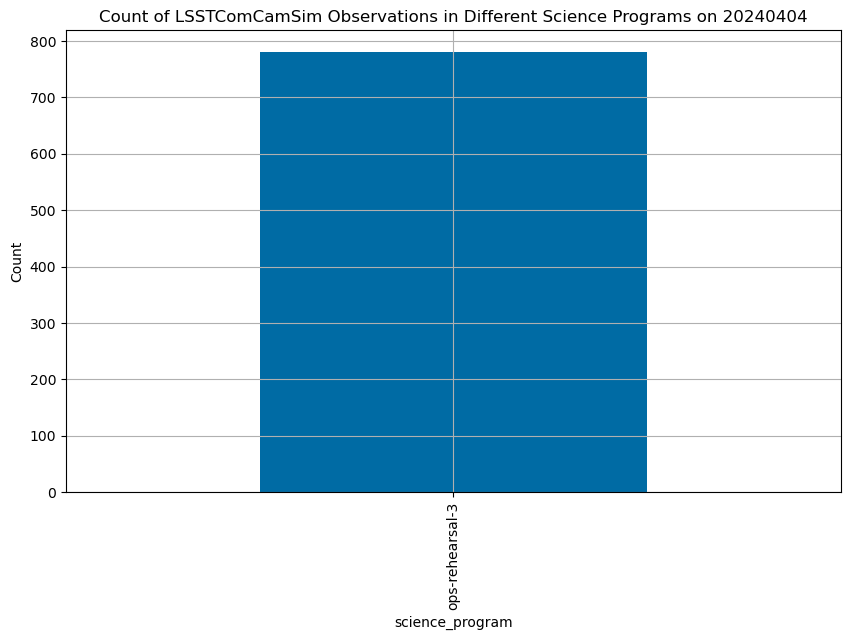

In [31]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science[col_sciprog].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_sciprog)
plt.ylabel('Count')
title = "Count of %s Observations in Different Science Programs on %s" % (instrument, day_obs)
plt.title(title)
plt.grid(True)


Now, let's look at the counts of exposures for the different targets observed on this date.

In [32]:
df_science.groupby(col_target).count()[col_id]

HPX64
19456      6
26965    119
27256     29
27258     90
31151     47
31493     13
40664     60
44033     14
44034     11
44035     94
44767     55
44788      1
44789     61
47513      4
47515     52
47518      4
47638     84
47644     36
Name: id, dtype: int64

Let's plot this as a 1D histogram.

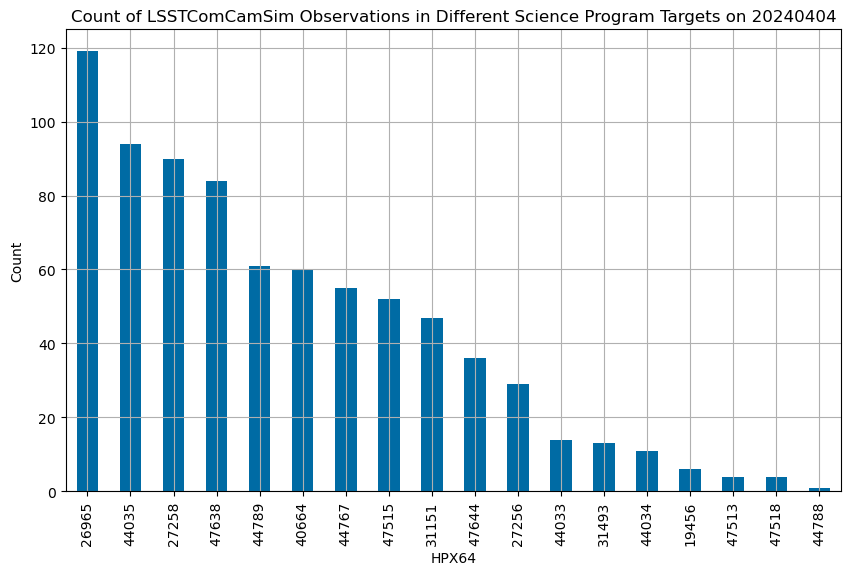

In [33]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
#value_counts = df_science['target'].value_counts()
value_counts = df_science[col_target].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_target)
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Let's organize these counts by both **science program** and **target**...

First, we will do a simple `groupby` command, using standard defaults.

In [34]:
df_science.groupby([col_sciprog,col_target]).count()[col_id]

science_program  HPX64
ops-rehearsal-3  19456      6
                 26965    119
                 27256     29
                 27258     90
                 31151     47
                 31493     13
                 40664     60
                 44033     14
                 44034     11
                 44035     94
                 44767     55
                 44788      1
                 44789     61
                 47513      4
                 47515     52
                 47518      4
                 47638     84
                 47644     36
Name: id, dtype: int64

We can make this look nicer (and more useful) by converting the results into a pandas DataFrame and outputting the tabular format.  We will make use of the `df2Dgroupby` function defined in Section 1.2.  In this case, we don't care about targets that have a count of 0; so we set the `fill_zeros` parameter to `False`.

In [35]:
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, False)
df_science_grouped

,science_program,HPX64,number
0,ops-rehearsal-3,19456,6
1,ops-rehearsal-3,26965,119
2,ops-rehearsal-3,27256,29
3,ops-rehearsal-3,27258,90
4,ops-rehearsal-3,31151,47
5,ops-rehearsal-3,31493,13
6,ops-rehearsal-3,40664,60
7,ops-rehearsal-3,44033,14
8,ops-rehearsal-3,44034,11
9,ops-rehearsal-3,44035,94


Let's plot these results as an annotated heatmap:

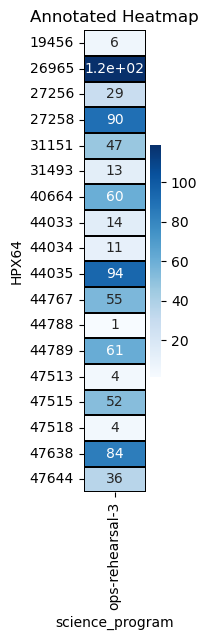

In [36]:
# First, we re-group df_science, setting the `fill_zeros` parameter back to `True`.  
#  This is mostly for aesthetic reasons for the plotting below (the value of '0' 
#  will be included in the annotations for those science_progam/target combos that
#  have no observations); otherwise those boxes will be left blank).
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, True)

# Now call the plotAnnotatedHeatMap_df2Dgroupby function defined in Section 1.2 above.
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_sciprog, 'number', title='Annotated Heatmap', cmap='Blues')


Now let's organize these counts by **target** and **filter**...  

In [37]:
df_science.groupby([col_target,col_filter]).count()[col_id]

HPX64  filter
19456  g_01       2
       i_06       2
       r_03       2
26965  g_01      40
       i_06      40
       r_03      39
27256  g_01       9
       i_06       9
       r_03      11
27258  g_01      30
       i_06      31
       r_03      29
31151  g_01      18
       i_06      15
       r_03      14
31493  g_01       2
       i_06       5
       r_03       6
40664  g_01      20
       i_06      20
       r_03      20
44033  g_01       5
       i_06       4
       r_03       5
44034  g_01       3
       i_06       4
       r_03       4
44035  g_01      31
       i_06      32
       r_03      31
44767  g_01      18
       i_06      19
       r_03      18
44788  r_03       1
44789  g_01      22
       i_06      19
       r_03      20
47513  g_01       2
       i_06       1
       r_03       1
47515  g_01      16
       i_06      19
       r_03      17
47518  g_01       2
       r_03       2
47638  g_01      28
       i_06      27
       r_03      29
47644  g_01      12
      

Again, we can convert the above results into a pandas DataFrame...

In [38]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, False)
df_science_grouped

,HPX64,filter,number
0,19456,g_01,2
1,19456,i_06,2
2,19456,r_03,2
3,26965,g_01,40
4,26965,i_06,40
5,26965,r_03,39
6,27256,g_01,9
7,27256,i_06,9
8,27256,r_03,11
9,27258,g_01,30


Here's the annotated heatmap of the same...

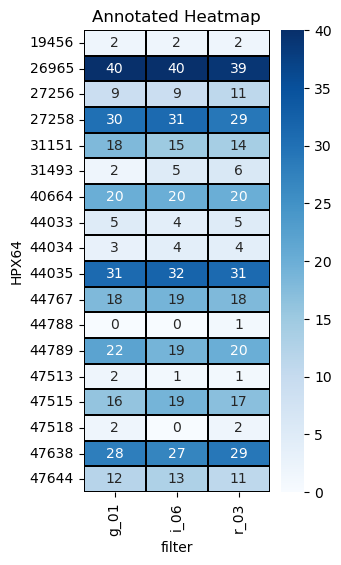

In [39]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, True)
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_filter, 'number', title='Annotated Heatmap', cmap='Blues')

Next, let's organize the counts by three variables: **science program**, **target**, and **filter**...  

In [40]:
df_science.groupby([col_sciprog,col_target,col_filter]).count()[col_id]

science_program  HPX64  filter
ops-rehearsal-3  19456  g_01       2
                        i_06       2
                        r_03       2
                 26965  g_01      40
                        i_06      40
                        r_03      39
                 27256  g_01       9
                        i_06       9
                        r_03      11
                 27258  g_01      30
                        i_06      31
                        r_03      29
                 31151  g_01      18
                        i_06      15
                        r_03      14
                 31493  g_01       2
                        i_06       5
                        r_03       6
                 40664  g_01      20
                        i_06      20
                        r_03      20
                 44033  g_01       5
                        i_06       4
                        r_03       5
                 44034  g_01       3
                        i_06       4
       

Convert this result into a pandas DataFrame using the `df3groupby` function defined in Section 1.2 above and display the resulting table:

In [41]:
df_science_grouped = df3Dgroupby(df_science, col_sciprog, col_target, col_filter, col_id, False)
df_science_grouped

,science_program,HPX64,filter,number
0,ops-rehearsal-3,19456,g_01,2
1,ops-rehearsal-3,19456,i_06,2
2,ops-rehearsal-3,19456,r_03,2
3,ops-rehearsal-3,26965,g_01,40
4,ops-rehearsal-3,26965,i_06,40
5,ops-rehearsal-3,26965,r_03,39
6,ops-rehearsal-3,27256,g_01,9
7,ops-rehearsal-3,27256,i_06,9
8,ops-rehearsal-3,27256,r_03,11
9,ops-rehearsal-3,27258,g_01,30


### 3.2 Positions

Plot RA, DEC...

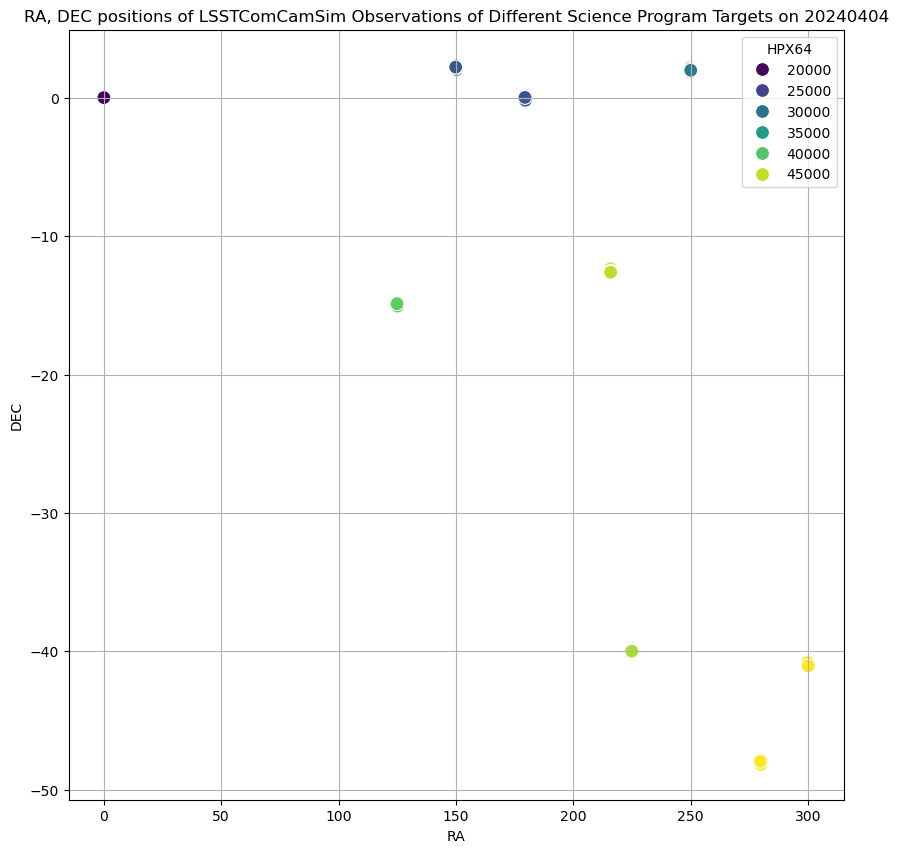

In [42]:
plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", s=100)
    for i, label in enumerate(df_science[col_target]):
        ax.annotate(label, (df_science['ra'][i], df_science['dec'][i]), fontsize=6)


# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

Plot target vs. zenith_angle:

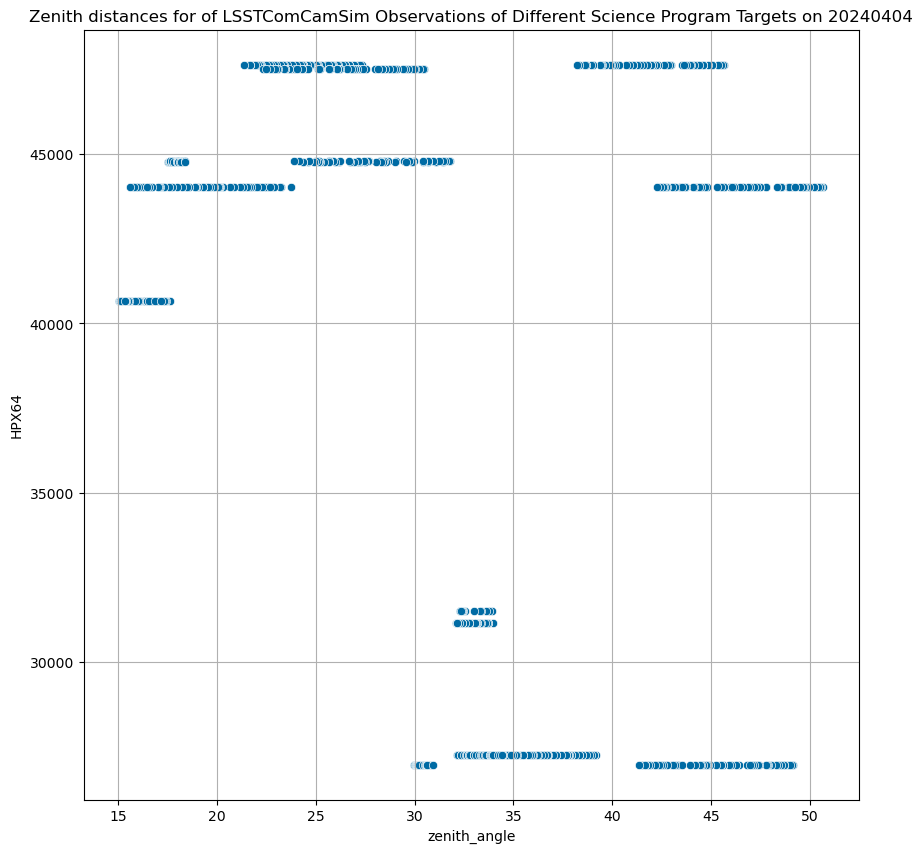

In [43]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y=col_target)

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot target vs. MJD:

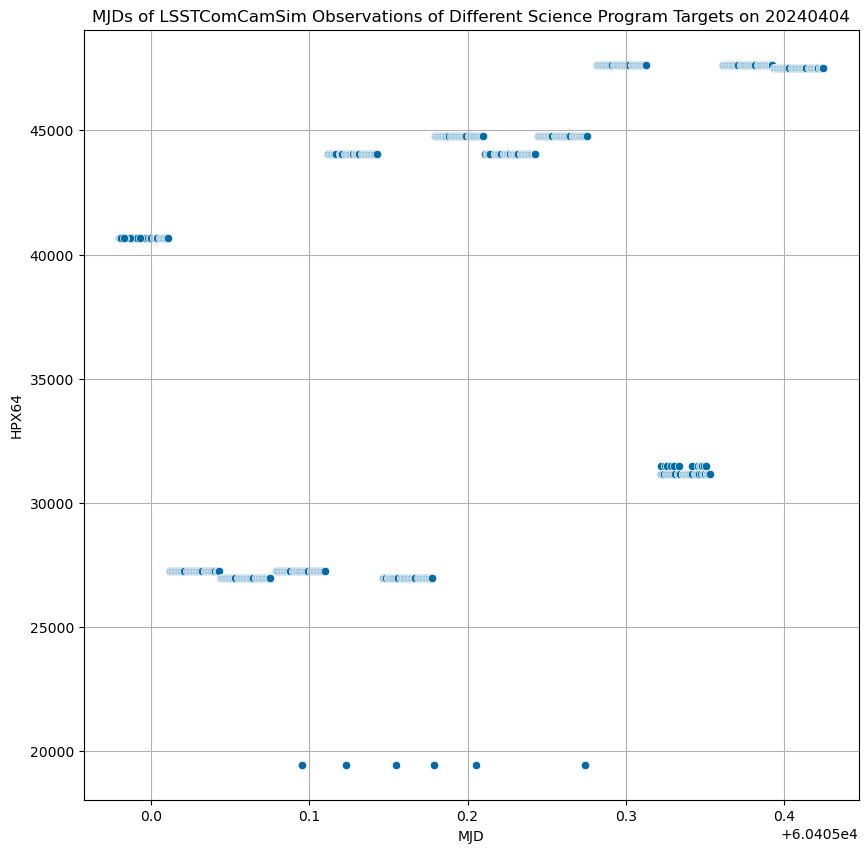

In [44]:
plt.figure(figsize=(10, 10))

#ax = sns.scatterplot(data=df_science, x="mjd", y="target")
ax = sns.scatterplot(data=df_science, x="mjd", y=col_target)


# Add labels and title
plt.xlabel('MJD')
plt.ylabel(col_target)
title = """MJDs of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


Plot zenith angle vs. MJD:

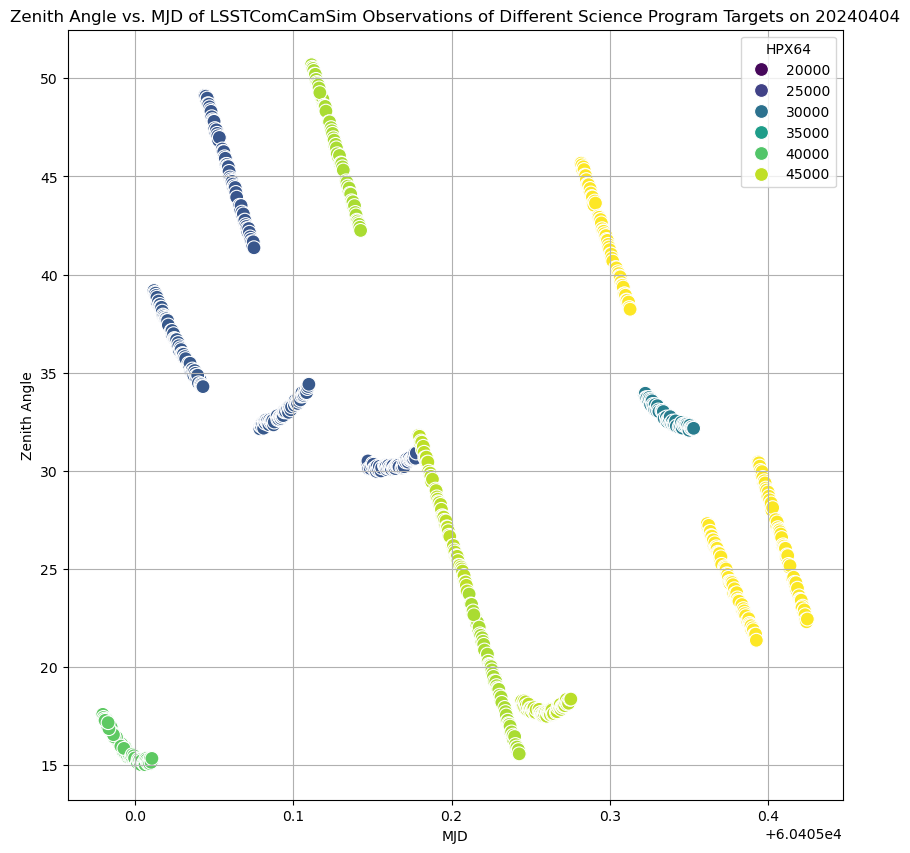

In [45]:
plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", s=100)
    for i, label in enumerate(df_science[col_target]):
        ax.annotate(label, (df_science['mjd'][i], df_science['zenith_angle'][i]), fontsize=6)

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('Zenith Angle')
title = """Zenith Angle vs. MJD of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

## 4. Final cleanup

Reset the pandas maximum rows option it its original default.

In [46]:
# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")

## Sandbox